In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


In [2]:
stellar_features = pd.read_csv("stellar_features.csv", index_col = 0)

In [3]:
print("Sample Shape :\n{} \n".format(stellar_features.shape))
print("Sample Data Types :\n{} \n".format(stellar_features.dtypes))


Sample Shape :
(87939, 7) 

Sample Data Types :
u           float64
g           float64
r           float64
i           float64
z           float64
redshift    float64
class        object
dtype: object 



In [4]:
print(stellar_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87939 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u         87939 non-null  float64
 1   g         87939 non-null  float64
 2   r         87939 non-null  float64
 3   i         87939 non-null  float64
 4   z         87939 non-null  float64
 5   redshift  87939 non-null  float64
 6   class     87939 non-null  object 
dtypes: float64(6), object(1)
memory usage: 5.4+ MB
None


In [5]:
features = ['u','g','r','i','z','redshift']
classes = stellar_features["class"].unique()
stellar_features.describe()

,u,g,r,i,z,redshift
count,87939.000000,87939.000000,87939.000000,87939.000000,87939.000000,87939.000000
mean,22.076154,20.630654,19.640179,19.079038,18.761662,0.583572
std,2.255119,2.039452,1.849442,1.751695,1.758200,0.734421
min,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971
25%,20.341365,18.960475,18.127585,17.726360,17.452335,0.060015
50%,22.166240,21.097100,20.130540,19.411060,19.009440,0.427993
75%,23.693860,22.111265,21.034150,20.387805,19.911320,0.705997
max,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


In [6]:
print(stellar_features.isna().sum())

u           0
g           0
r           0
i           0
z           0
redshift    0
class       0
dtype: int64


In [7]:
stellar_features_long = stellar_features.melt(id_vars = "class", value_vars = features, var_name="feature", value_name = "value")
stellar_features_long


,class,feature,value
0,GALAXY,u,23.878820
1,GALAXY,u,24.777590
2,GALAXY,u,25.263070
3,GALAXY,u,19.437180
4,QSO,u,23.488270
...,...,...,...
527629,GALAXY,redshift,0.587944
527630,GALAXY,redshift,0.404895
527631,GALAXY,redshift,0.143366
527632,GALAXY,redshift,0.455040


In [8]:
## Building CDFs

def cdf_plot(array, theor="normal"):
    """Plots the CDF of the given array against its theoretical"""
    from matplotlib.pyplot import figure
    figure(figsize=(5, 3), dpi=150)
    x = np.sort(array)
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker='.', linestyle='none', label = "Observed CDF", markersize = 0.03, color = "red")
    
    if theor == "normal":
        x = np.sort(np.random.normal(np.mean(array), np.std(array), size=len(array)))
        y = np.arange(1, len(x)+1) / len(x)
        _ = plt.plot(x, y, marker='.', linestyle='none', color = "green", label = "Theoretical CDF", markersize = 0.03)
    elif theor == "exponential":
        x = np.sort(np.random.exponential(np.mean(array), size=len(array)))
        y = np.arange(1, len(x)+1) / len(x)
        _ = plt.plot(x, y, marker='.', linestyle='none', color = "green", label = "Theoretical CDF", markersize = 0.03)

        

In [9]:
features

['u', 'g', 'r', 'i', 'z', 'redshift']

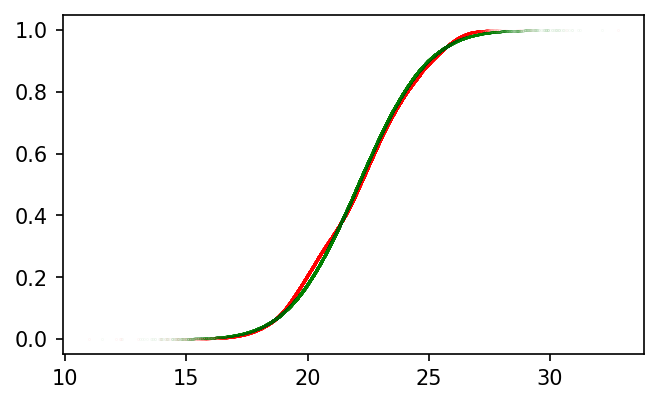

In [10]:
cdf_plot(stellar_features["u"], theor = "normal")

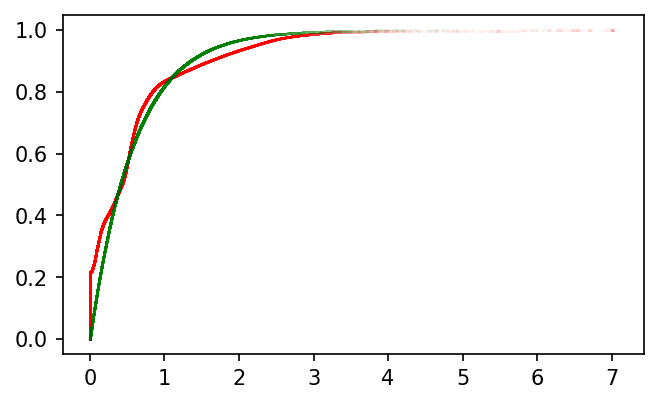

In [11]:
cdf_plot(stellar_features["redshift"], theor = "exponential")

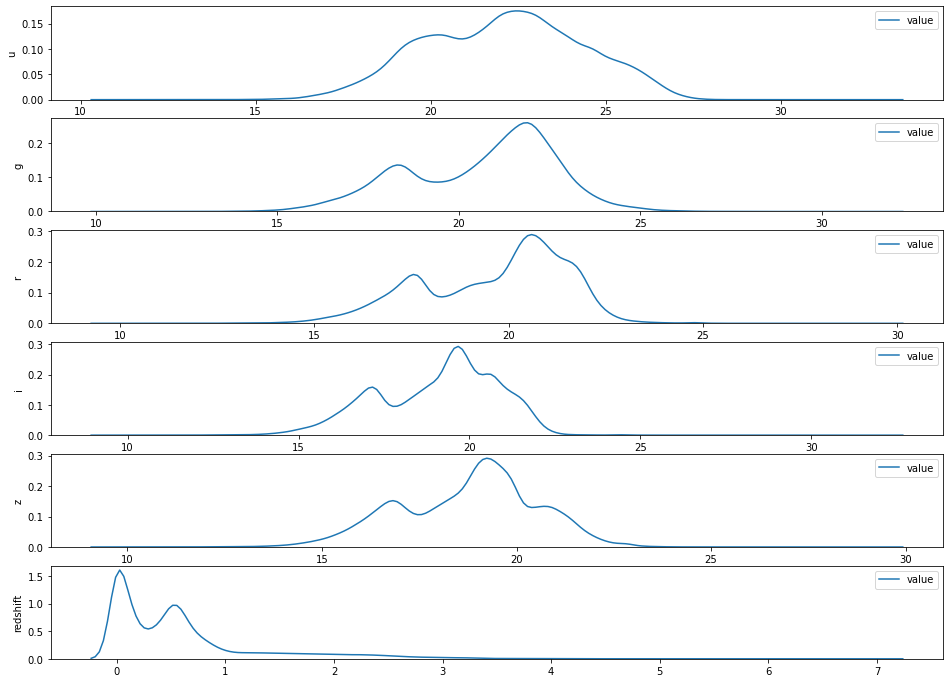

In [12]:
import seaborn as sns

fig, ax = plt.subplots(6,1)
fig.set_size_inches([16, 12])

for i in range(6):
        sns.kdeplot(data = stellar_features_long[stellar_features_long["feature"].isin([features[i]])], ax = ax[i])
        ax[i].set(ylabel = features[i])
#sns.kdeplot(x = "value", kind = "kde", data = stellar_features_long, col = "class", row = "feature")
plt.show()


There is some overlapping in the signals as we can see from CDFs and PDFs of the features. While others are close to normal distribution, have got multiple peaks though, redshift is close to an exponential distribution.

It could be said that there is some amalgamation of signals from various stellar bodies here, which using suitable statistical and machine learning methods can be extracted/estimated.


In [13]:
print(stellar_features["class"].unique())

## Saving class as a category
stellar_features["class"] = stellar_features["class"].astype("category")
stellar_features.dtypes

['GALAXY' 'QSO' 'STAR']


u            float64
g            float64
r            float64
i            float64
z            float64
redshift     float64
class       category
dtype: object

### Checking and handling multicollinearity

                 u         g         r         i         z  redshift
u         1.000000  0.853347  0.727495  0.615436  0.541491  0.158087
g         0.853347  1.000000  0.931925  0.844366  0.770890  0.312706
r         0.727495  0.931925  1.000000  0.962108  0.917534  0.431491
i         0.615436  0.844366  0.962108  1.000000  0.971108  0.493881
z         0.541491  0.770890  0.917534  0.971108  1.000000  0.503812
redshift  0.158087  0.312706  0.431491  0.493881  0.503812  1.000000


<AxesSubplot:>

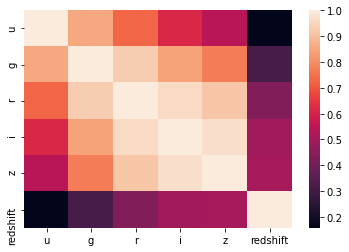

In [14]:
print(stellar_features.corr())
sns.heatmap(stellar_features.corr())


In [15]:
# u and g are collinear
# g,r,i,z are collinear
# Removing r,i

stellar_features_new = stellar_features.drop(columns = ['r','i'])
features_new = ['u','g','z','redshift']
stellar_features_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87939 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         87939 non-null  float64 
 1   g         87939 non-null  float64 
 2   z         87939 non-null  float64 
 3   redshift  87939 non-null  float64 
 4   class     87939 non-null  category
dtypes: category(1), float64(4)
memory usage: 3.4 MB


### Creating and test splits

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(stellar_features_new[features_new],stellar_features_new["class"], test_size=0.2, stratify=stellar_features_new["class"] ,random_state=21)

print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(70351, 4)
(17588, 4)
(70351,)
(17588,)


### Encoding target variable

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train[:])
y_test = le.transform(y_test[:])


## Modeling Iteration 1

In [18]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline


## n_neighbors identified through GridSearchCV on values between 4 and 12.

def stellar_cv_classifier(model, X, y, params, scaler):
    """This function returns a GridSearchCV object and prints some accuracy scores
        model can take the values: Logistic, RandomForest, KNN, GBC
        scaler can be min_max((0,1)) or standard or.
        
        Create params just like you would for GridSearchCV in pipeline. 
        params = {'Classifier__(parameter name))}':[Parameter Values List]}
        Example : parameters = {'Classifier__n_neighbors': [6,7]} """
    
    
    
    if scaler == "standard":
        scaler = StandardScaler()
    elif scaler == "min_max":
        scaler = MinMaxScaler((0,1))
    
    if model == "Logistic":
        ## Logistic
        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression(max_iter=1000)
    
    elif model == "RandomForest":
        ### Random Forest
        from sklearn.ensemble import RandomForestClassifier
        classifier = RandomForestClassifier(random_state=123)

    elif model == "KNN":
        ### KNN Classifier
        from sklearn.neighbors import KNeighborsClassifier
        classifier = KNeighborsClassifier(n_neighbors = 6) 

    elif model == "GBC":
        ### Getting Gradient Boost
        from sklearn.ensemble import GradientBoostingClassifier 
        classifier = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=20)
    
    elif model == "LinearSVC":
        ### Linear SVC
        from sklearn.svm import LinearSVC
        classifier = LinearSVC(random_state=20)
        


    #### Setting the pipeline
    steps = [("Scaler",scaler),("Classifier",classifier)]
    model_pipeline = Pipeline(steps)



    cv = GridSearchCV(model_pipeline, param_grid=params, cv = 4)
    cv.fit(X, y)
    
    #### Evaluation
    print("Best Parameters {}".format(cv.best_params_))
    print("\n CV Accuracy {}".format(cv.best_score_*100))


    #### Error Analysis
    print("Error Analysis")
    y_pred = cv.predict(X)

    from sklearn.metrics import confusion_matrix
    print("\n Confusion Matrix: \n")
    print(confusion_matrix(y, y_pred))
    
    return(cv)



In [83]:
logreg_parameters = {'Classifier__max_iter': [1000]}
logreg = stellar_cv_classifier(model = "Logistic", X = X_train, y = y_train, params = logreg_parameters, scaler = "standard")

print("\n Train Accuracy ",logreg.score(X_train,y_train)*100)
print("\n Test Accuracy ",logreg.score(X_test,y_test)*100)


Best Parameters {'Classifier__max_iter': 1000}

 CV Accuracy 95.44142921937488
Error Analysis

 Confusion Matrix: 

[[40188   697   807]
 [ 1642 12147     8]
 [    1     3 14858]]

 Train Accuracy  95.51108015522168

 Test Accuracy  95.64475778940187


In [84]:
rf_parameters = {'Classifier__n_estimators': [400], 'Classifier__min_samples_leaf':[0.15]}
rf = stellar_cv_classifier(model = "RandomForest", X = X_train, y = y_train, params = rf_parameters, scaler = "standard")

print("\n Train Accuracy ",rf.score(X_train,y_train)*100)
print("\n Test Accuracy ",rf.score(X_test,y_test)*100)


Best Parameters {'Classifier__min_samples_leaf': 0.15, 'Classifier__n_estimators': 400}

 CV Accuracy 87.07339184841223
Error Analysis

 Confusion Matrix: 

[[37352  2523  1817]
 [ 4662  9124    11]
 [    0     0 14862]]

 Train Accuracy  87.18852610481727

 Test Accuracy  87.43461450989311


In [85]:
knn_parameters = {'Classifier__n_neighbors': [4,5,6,7,8]}
knn = stellar_cv_classifier(model = "KNN", X = X_train, y = y_train, params = knn_parameters, scaler = "standard")

print("\n Train Accuracy ",knn.score(X_train,y_train)*100)
print("\n Test Accuracy ",knn.score(X_test,y_test)*100)


Best Parameters {'Classifier__n_neighbors': 5}

 CV Accuracy 96.02279951326547
Error Analysis

 Confusion Matrix: 

[[40491   429   772]
 [  854 12923    20]
 [  129     1 14732]]

 Train Accuracy  96.86571619451038

 Test Accuracy  96.12235615192176


In [86]:
gbc_parameters = {'Classifier__n_estimators': [200],'Classifier__learning_rate' : [1],'Classifier__max_depth':[1]}
gbc = stellar_cv_classifier(model = "GBC", X = X_train, y = y_train, params = gbc_parameters, scaler = "standard")

print("\n Train Accuracy ",gbc.score(X_train,y_train)*100)
print("\n Test Accuracy ",gbc.score(X_test,y_test)*100)


Best Parameters {'Classifier__learning_rate': 1, 'Classifier__max_depth': 1, 'Classifier__n_estimators': 200}

 CV Accuracy 97.17843573051864
Error Analysis

 Confusion Matrix: 

[[41045   561    86]
 [ 1131 12663     3]
 [   25     0 14837]]

 Train Accuracy  97.43287231169421

 Test Accuracy  97.44143734364339


In [87]:
svc_parameters  = {'Classifier__max_iter': [2000]}
svc = stellar_cv_classifier(model = "LinearSVC", X = X_train, y = y_train, params = svc_parameters, scaler = "standard")

print("\n Train Accuracy ",svc.score(X_train,y_train)*100)
print("\n Test Accuracy ",svc.score(X_test,y_test)*100)


Best Parameters {'Classifier__max_iter': 2000}

 CV Accuracy 93.1187916994326
Error Analysis

 Confusion Matrix: 

[[39691  1382   619]
 [ 1254 12538     5]
 [ 1544     0 13318]]

 Train Accuracy  93.17138349135051

 Test Accuracy  93.33636570388902


## Modeling Iteration 2

In [88]:
## Function to return polynomial features

def features_poly(X_train, X_test, deg, bias_term = False, interaction_only = True):
    
    print("X_train Shape: {}".format(X_train.shape))
    
    from sklearn.preprocessing import PolynomialFeatures
    
    interaction = PolynomialFeatures(degree=deg, interaction_only=interaction_only, include_bias=bias_term)
    X_train_poly = interaction.fit_transform(X_train)
    X_test_poly = interaction.fit_transform(X_test)
    
    print("X_train with interact Shape: {}".format(X_train_poly.shape))
    print("X_test with interact Shape: {}".format(X_test_poly.shape))
    
    return(X_train_poly, X_test_poly)

In [114]:
## Function to return balanced training datasets
def class_balancer(X, y):
    """Gives out model data with no class balance.
    Oversamples the smaller class to 30k using SMOTE and
    undersamples the bigger class to 30k using random undersampler"""
    # Importing Packages
    from imblearn.over_sampling import SMOTE 
    from imblearn.under_sampling import RandomUnderSampler

    # Undersampling (majority class - 30000)
    us = RandomUnderSampler(sampling_strategy={0: 30000}, random_state=42)
    os = SMOTE(sampling_strategy = {1:30000,2:30000} , random_state=42)

    X_samp, y_samp = us.fit_resample(X, y)
    X_samp, y_samp = os.fit_resample(X_samp, y_samp)

    print(f'''Shape of X before SMOTE: {X.shape}
    Shape of X after SMOTE: {X_samp.shape}''')

    print('\nBalanced classes (%):')
    print(pd.Series(y_samp).value_counts())
    
    return(X_samp, y_samp)


### Logistic Regression with Polynomial Features

In [90]:
X_tr,X_ts = features_poly(X_train, X_test, deg = 2, bias_term = False, interaction_only = True)

logreg_parameters = {'Classifier__max_iter': [2000], 'Classifier__C': [0.5], 'Classifier__penalty': ['l2']}
logreg = stellar_cv_classifier(model = "Logistic", X = X_tr, y = y_train, params = logreg_parameters, scaler = "standard")

print("\n Train Accuracy ",logreg.score(X_tr,y_train)*100)
print("\n Test Accuracy ",logreg.score(X_ts,y_test)*100)


X_train Shape: (70351, 4)
X_train with interact Shape: (70351, 10)
X_test with interact Shape: (17588, 10)
Best Parameters {'Classifier__C': 0.5, 'Classifier__max_iter': 2000, 'Classifier__penalty': 'l2'}

 CV Accuracy 96.05264860269888
Error Analysis

 Confusion Matrix: 

[[40427   527   738]
 [ 1408 12382     7]
 [   17     1 14844]]

 Train Accuracy  96.1649443504712

 Test Accuracy  96.24175574255173


### Gradient Boosting Classifier (GBC) with Polynomial Features

In [91]:
X_tr,X_ts = features_poly(X_train, X_test, deg = 2, bias_term = False, interaction_only = True)

gbc_parameters = {'Classifier__n_estimators': [200],'Classifier__learning_rate' : [1],'Classifier__max_depth':[1]}
gbc = stellar_cv_classifier(model = "GBC", X = X_tr, y = y_train, params = gbc_parameters, scaler = "standard")

print("\n Train Accuracy ",gbc.score(X_tr,y_train)*100)
print("\n Test Accuracy ",gbc.score(X_ts,y_test)*100)


X_train Shape: (70351, 4)
X_train with interact Shape: (70351, 10)
X_test with interact Shape: (17588, 10)
Best Parameters {'Classifier__learning_rate': 1, 'Classifier__max_depth': 1, 'Classifier__n_estimators': 200}

 CV Accuracy 97.24097910063126
Error Analysis

 Confusion Matrix: 

[[41043   554    95]
 [ 1101 12693     3]
 [   17     0 14845]]

 Train Accuracy  97.48404429219201

 Test Accuracy  97.43006595405959


### Gradient Boosting Classifier (GBC) with Balanced Classes

In [117]:
X_tr_samp, y_tr_samp = class_balancer(X_train, y_train)

gbc_parameters = {'Classifier__n_estimators': [200],'Classifier__learning_rate' : [1],'Classifier__max_depth':[1]}
gbc = stellar_cv_classifier(model = "GBC", X = X_tr_samp, y = y_tr_samp, params = gbc_parameters, scaler = "standard")

print("\n Train Accuracy ",gbc.score(X_tr_samp,y_tr_samp)*100)
print("\n Test Accuracy ",gbc.score(X_test,y_test)*100)


Shape of X before SMOTE: (70351, 4)
    Shape of X after SMOTE: (90000, 4)

Balanced classes (%):
0    30000
1    30000
2    30000
dtype: int64
Best Parameters {'Classifier__learning_rate': 1, 'Classifier__max_depth': 1, 'Classifier__n_estimators': 200}

 CV Accuracy 96.86111111111111
Error Analysis

 Confusion Matrix: 

[[28899   856   245]
 [ 1516 28481     3]
 [    0     0 30000]]

 Train Accuracy  97.08888888888889

 Test Accuracy  96.68523993632022


### Gradient Boosting Classifier (GBC) with Balanced Classes and Polynomial Features

In [118]:
X_tr_samp, y_tr_samp = class_balancer(X_train, y_train)
X_tr, X_ts = features_poly(X_tr_samp, X_test, deg = 2, bias_term = False, interaction_only = True)

gbc_parameters = {'Classifier__n_estimators': [200],'Classifier__learning_rate' : [1],'Classifier__max_depth':[1]}
gbc = stellar_cv_classifier(model = "GBC", X = X_tr, y = y_tr_samp, params = gbc_parameters, scaler = "standard")

print("\n Train Accuracy ",gbc.score(X_tr,y_tr_samp)*100)
print("\n Test Accuracy ",gbc.score(X_ts,y_test)*100)


Shape of X before SMOTE: (70351, 4)
    Shape of X after SMOTE: (90000, 4)

Balanced classes (%):
0    30000
1    30000
2    30000
dtype: int64
X_train Shape: (90000, 4)
X_train with interact Shape: (90000, 10)
X_test with interact Shape: (17588, 10)
Best Parameters {'Classifier__learning_rate': 1, 'Classifier__max_depth': 1, 'Classifier__n_estimators': 200}

 CV Accuracy 96.89777777777778
Error Analysis

 Confusion Matrix: 

[[28837   901   262]
 [ 1466 28531     3]
 [    8     0 29992]]

 Train Accuracy  97.06666666666666

 Test Accuracy  96.62838298840119


## Final Model
##### ### Building the final GBC Model and evaluating on Test Data

In [119]:

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

scaler = StandardScaler()
classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=20)
steps = [("Scaler",scaler),("Classifier",classifier)]

gbc_pipeline = Pipeline(steps)
gbc_pipeline.fit(X_train,y_train)

print("\n Train Accuracy ",gbc_pipeline.score(X_train,y_train)*100)
print("\n Test Accuracy ",gbc_pipeline.score(X_test,y_test)*100)

y_pred = gbc_pipeline.predict(X_test)
print("\n Test Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print("\n Test Classification Report \n",classification_report(y_test, y_pred))



 Train Accuracy  97.43287231169421

 Test Accuracy  97.44143734364339

 Test Confusion Matrix 
 [[10263   134    26]
 [  285  3164     0]
 [    4     1  3711]]

 Test Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     10423
           1       0.96      0.92      0.94      3449
           2       0.99      1.00      1.00      3716

    accuracy                           0.97     17588
   macro avg       0.97      0.97      0.97     17588
weighted avg       0.97      0.97      0.97     17588



# Evaluation

Model Iteration 1:
    Tried 5 algorithms for training the classifier out of which Logistic, KNN and Gradient Boost (GBC) worked the best.
    Both the cross- validation
    
    A quick look at the error analysis, shows that the the classifier has tough time predicting quasars mostly along with falsely predicting the Galaxies as Stars/Quasars.
    
    Moving Forward with Logistic and GBC classifier because of their accuracy.
    
Model Iteration 2:
    Tried adding polynomial features of degree 2 and 3, with and without interations to train the model. This did not increase the accuracy.
    Tried training the classifier on balanced classes. This did not help with the accuracy.
    

With StandardScaler and 
1. Logistic Regression: 95.44 CV, 95.64 Test%
2. Gradient Boost:
                1. 97.18 CV , 97.42 Test
3. KNN: 95.95% CV, 96.08% Test
4. Random Forest : 92.94 CV, 93.20%

Model Seems to have bias, since our training erorr and test error come out to be very close every time, surprisingly  the CV error is slightly more sometimes.

Error Analysis:
More of QSOs are being predicted as Galaxies. This could be possible since there is class imbalance and Galaxies have the maximum instances.

Will Try all again with:
1. Adding Interaction terms with polynomial features.
2. Handling Class Imbalance
